# Balancing a Pole on a Cart

SCSB:
- Xuan Ming (U2220719A)
- Siah Yee Long (U2220887B)


## Importing dependencies and define helper functions

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pickle
import os
import time

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [3]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01143666 -0.02176188  0.01547731  0.0387908 ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02428938 -0.17683071  0.01494589  0.33169147]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()

cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

### Pre-training set-up

We first set up the limits of the environment. While this is the observation space of the cartpole problem

| Observation            | Min               | Max               |
|------------------------|------------------|------------------|
| Cart Position         | -4.8              | 4.8              |
| Cart Velocity        | -Inf              | Inf              |
| Pole Angle          | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| Pole Angular Velocity | -Inf              | Inf              |

we have decided to set the bounds of the Cart Velocity to ±3, and the Pole Angular Velocity to ±10. If they were set to ∞, or just a very big number, it would be impractical to bin them into a finite number of bins. This would make the resolution of each state low, and the memory required to run the algorithm impractically large. Hence, the final observation space we've decided on is as such:

| Observation            | Min               | Max               |
|------------------------|------------------|------------------|
| Cart Position         | -4.8              | 4.8              |
| Cart Velocity        | -3              | 3              |
| Pole Angle          | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| Pole Angular Velocity | -10              | 10              |

The number of bins is set to 30 for all vector elements. This means a cart position ranging from -4.8 to 4.8 will be chopped into 30 equal parts. Hence, a position value of 3.14 will be represented as index 25 because:


$\frac{4.8-(-4.8)}{30}=0.32$

$x = \left\lceil \frac{3.14-(-4.8)}{0.32} \right\rceil = 25$



In [6]:
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

bins=30
numberOfBinsPosition=bins
numberOfBinsVelocity=bins
numberOfBinsAngle=bins
numberOfBinsAngleVelocity=bins
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]

### 1a) Monte Carlo agent
#### Why Monte Carlo?
The essence of Monte Carlo (MC) is to use randomness to solve problems. Sampling the state and action space and observing the patterns.
It is partciularly suitable for the cartpole problem as it is an episodic environment, the state and action space are reasonably small (after discrete representation. Therefore, due to the problem at hand, the sampling can be done and convergence can be attained, without strong computing resource.

#### First-Visit MC
We have decided to use the first-visit policy to update Q-values at the end of an episode. This means that Q-values are updated using values from the first occurence of a state and action pair in an episode. First-visit was chosen as it is a model-free algorithm.

#### Implementation Overview

The MonteCarlo class will:
1. Implement the Monte Carlo algorithm with the selectActions, returnIndexState helper functions, initialise arbitrary Q table values.
2. Simulate the environment using the first-visit policy in the policy evaluation phase.
3. Stores the sequence of state, action and reward until the episode terminates.
4. Policy improvement, compute returns, discounting future rewards.
5. Update the Q Table if it is the first visit for a given (state, action).
6. Update policy value table.

#### Implementation Details
Class functions:
- `_ _ init _ _` initialises the class
- `returnIndexState` discretizes a given state into its corresponding index
- `selectAction` selects an action according to the current episode number to learn a strategy
- `simulateEpisodes` iterates through the stated episode(s) to learn the strategy
- `simulateLearnedStrategy` with the learnt policy, run a simulation for a stated amount of episode(s)
- `save_pickle` saves the learnt model as a pickle file
- `load_pickle` loads the learnt model from a pickle file



In [7]:
class MonteCarloAgent:
    ###########################################################################
    #   START - __init__ function
    ###########################################################################
    # INPUTS:
    # env - Cart Pole environment
    # alpha - learning rate
    # gamma - discount factor
    # epsilon - exploration rate

    # numberOfBins - this is a 4 dimensional list that defines the number of grid points
    # for state discretization
    # that is, this list contains number of bins for every state entry,
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity

    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # usePickle (optional) - loads model from pickle file if set to true. when set to true, all other parameters are not needed
    def __init__(self, env=None, gamma=None, epsilon=None, numberEpisodes=None, numberOfBins=None, lowerBounds=None, upperBounds=None, usePickle=False):
        if usePickle:
            self.load_pickle('MCagent.pkl')
        else:
            self.env = env
            self.gamma = gamma
            self.epsilon = epsilon
            self.numberEpisodes = numberEpisodes
            self.numberOfBins = numberOfBins
            self.lowerBounds = lowerBounds
            self.upperBounds = upperBounds
            self.actionNumber = env.action_space.n
            self.history = []
            self.sumRewardsEpisode = []

            self.returns = {}  # Store cumulative rewards per state-action pair
            self.policy = np.random.choice(self.actionNumber, size=(numberOfBins[0], numberOfBins[1], numberOfBins[2], numberOfBins[3]))
            self.Qmatrix = np.zeros((numberOfBins[0], numberOfBins[1], numberOfBins[2], numberOfBins[3], self.actionNumber))

            self.visits = np.zeros_like(self.Qmatrix, dtype=int)
    ###########################################################################
    #   END - __init__ function
    ###########################################################################


    ###########################################################################
    # START: function "returnIndexState"
    ###########################################################################
    # for the given 4-dimensional state, and discretization grid defined by
    # numberOfBins, lowerBounds, and upperBounds, this function will return
    # the index tuple (4-dimensional) that is used to index entries of the
    # of the QvalueMatrix

    # INPUTS:
    # state - state list/array, 4 entries:
    # cart position, cart velocity, pole angle, and pole angular velocity

    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix
    # that correspond to "state" input
    def returnIndexState(self, state):
        cartPositionBin = np.linspace(self.lowerBounds[0], self.upperBounds[0], self.numberOfBins[0])
        cartVelocityBin = np.linspace(self.lowerBounds[1], self.upperBounds[1], self.numberOfBins[1])
        poleAngleBin = np.linspace(self.lowerBounds[2], self.upperBounds[2], self.numberOfBins[2])
        poleAngleVelocityBin = np.linspace(self.lowerBounds[3], self.upperBounds[3], self.numberOfBins[3])

        indexPosition = np.maximum(np.digitize(state[0], cartPositionBin) - 1, 0)
        indexVelocity = np.maximum(np.digitize(state[1], cartVelocityBin) - 1, 0)
        indexAngle = np.maximum(np.digitize(state[2], poleAngleBin) - 1, 0)
        indexAngularVelocity = np.maximum(np.digitize(state[3], poleAngleVelocityBin) - 1, 0)

        return (indexPosition, indexVelocity, indexAngle, indexAngularVelocity)
    ###########################################################################
    # END: function "returnIndexState"
    ###########################################################################


    ###########################################################################
    #    START - function for selecting an action: epsilon-greedy approach
    ###########################################################################
    def selectAction(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return self.policy[self.returnIndexState(state)]
    ###########################################################################
    #    START - function for selecting an action: epsilon-greedy approach
    ###########################################################################


    ###########################################################################
    #    START - function for simulating learning episodes
    ###########################################################################
    def simulateEpisodes(self):
        for indexEpisode in range(self.numberEpisodes):
            state = self.env.reset()
            state = list(state)
            episode = []
            terminalState = False

            # Policy evaluation, generate episodes using policy till terminal states
            while not terminalState:
                action = self.selectAction(state)
                next_state, reward, terminalState, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = list(next_state)

            G = 0
            visited = set()
            # Policy improvement
            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = self.gamma * G + reward
                stateIndex = self.returnIndexState(state)
                sa_pair = (stateIndex, action)

                # For first time only
                if sa_pair not in visited:
                    visited.add(sa_pair)
                    self.visits[stateIndex + (action,)] += 1
                    self.Qmatrix[stateIndex + (action,)] += (G - self.Qmatrix[stateIndex + (action,)]) / self.visits[stateIndex + (action,)]
                    self.policy[stateIndex] = np.argmax(self.Qmatrix[stateIndex])

            rewardsThisEpisode = sum([x[2] for x in episode])
            if(indexEpisode % 100 == 0):
              print(f"Sum of rewards {rewardsThisEpisode} for episode number {indexEpisode}")
            self.sumRewardsEpisode.append(rewardsThisEpisode)

        self.save_pickle('MCagent.pkl')
    ###########################################################################
    #    END - function for simulating learning episodes
    ###########################################################################


    ###########################################################################
    #    START - function for simulating the final learned optimal policy
    ###########################################################################
    # OUTPUTS:
    # obtainedRewards - the sum of obtained rewards from this simulated gameplay
    def simulateLearnedStrategy(self, renderVideo=False):
        if renderVideo:
          env1 = RecordVideo(gym.make("CartPole-v1"), "./video")
          currentState = env1.reset()
          obtainedRewards=[]
          done = False
          while not done:
              env1.render()
              #your agent goes here
              action = self.policy[self.returnIndexState(currentState)]
              currentState, reward, done, info = env1.step(action)
              obtainedRewards.append(reward)
          env1.close()
          show_video()
          print(f"Simulation ended. Results achieved: {np.sum(obtainedRewards)}")
          return
        else:
          env1 = gym.make('CartPole-v1', render_mode='human')
          state = env1.reset()
          state = list(state)
          obtainedRewards = []
          terminalState = False

          while not terminalState:
              action = self.policy[self.returnIndexState(state)]
              state, reward, terminalState, _ = env1.step(action)
              obtainedRewards.append(reward)

          env1.close()
          # print(f"Total rewards: {sum(obtainedRewards)}")
          return obtainedRewards
    ###########################################################################
    #    END - function for simulating the final learned optimal policy
    ###########################################################################


    ###########################################################################
    #    START - function for serializing monte carlo model as a pickle file
    ###########################################################################
    # INPUTS:
    # filename - the filename of the pickle file
    def save_pickle(self, filename: str):
        with open(filename, 'wb') as file:
            pickle.dump({
                'gamma': self.gamma,
                'epsilon': self.epsilon,
                'numberEpisodes': self.numberEpisodes,
                'numberOfBins': self.numberOfBins,
                'lowerBounds': self.lowerBounds,
                'upperBounds': self.upperBounds,
                'sumRewardsEpisode': self.sumRewardsEpisode,
                'Qmatrix': self.Qmatrix,
                'policy': self.policy
            }, file)
    ###########################################################################
    #    END - function for de-serializing monte carlo model as a pickle file
    ###########################################################################


    ###########################################################################
    #    START - function for de-serializing monte carlo model as a pickle file
    ###########################################################################
    # INPUTS:
    # filename - the filename of the pickle file
    def load_pickle(self, filename: str):
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                data = pickle.load(file)
                self.gamma = data['gamma']
                self.epsilon = data['epsilon']
                self.numberEpisodes = data['numberEpisodes']
                self.numberOfBins = data['numberOfBins']
                self.lowerBounds = data['lowerBounds']
                self.upperBounds = data['upperBounds']
                self.sumRewardsEpisode = data['sumRewardsEpisode']
                self.Qmatrix = data['Qmatrix']
                self.policy = data['policy']
        else:
            print("Pickle file not found!")
    ###########################################################################
    #    END - function for de-serializing monte carlo model as a pickle file
    ###########################################################################

We set the Monte Carlo Agent hyperparameters of

`γ (gamma)` : 0.9 (the paramter to discount future rewards)

`ε (epsilon)` : 0.2 (the parameter to encourage exploration higher value means greater exploration)

Then, run and save the model as monte_carlo_agent

In [8]:
def start_monte_carlo(g,e, episodes) -> MonteCarloAgent:
  # define the parameters
  gamma=g
  epsilon=e
  #print(f"g = {g}, e = {e}")
  numberEpisodes=episodes

  # create a MonteCarloAgent object
  MC1=MonteCarloAgent(env,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds, False)
  # run the MonteCarloAgent algorithm
  MC1.simulateEpisodes()
  print("Done learning")
  return MC1

In [11]:
monte_carlo_agent = start_monte_carlo(0.9,0.2, 10000)

Sum of rewards 39.0 for episode number 0
Sum of rewards 115.0 for episode number 100
Sum of rewards 86.0 for episode number 200
Sum of rewards 110.0 for episode number 300
Sum of rewards 132.0 for episode number 400
Sum of rewards 94.0 for episode number 500
Sum of rewards 185.0 for episode number 600
Sum of rewards 186.0 for episode number 700
Sum of rewards 122.0 for episode number 800
Sum of rewards 152.0 for episode number 900
Sum of rewards 152.0 for episode number 1000
Sum of rewards 168.0 for episode number 1100
Sum of rewards 196.0 for episode number 1200
Sum of rewards 282.0 for episode number 1300
Sum of rewards 241.0 for episode number 1400
Sum of rewards 110.0 for episode number 1500
Sum of rewards 400.0 for episode number 1600
Sum of rewards 161.0 for episode number 1700
Sum of rewards 316.0 for episode number 1800
Sum of rewards 281.0 for episode number 1900
Sum of rewards 98.0 for episode number 2000
Sum of rewards 152.0 for episode number 2100
Sum of rewards 290.0 for e

Show learning performance over episodes. Notice that the rewards gained across episodes are sporadic, but improves significantly over time.

<ipython-input-12-28d37cf69a50>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


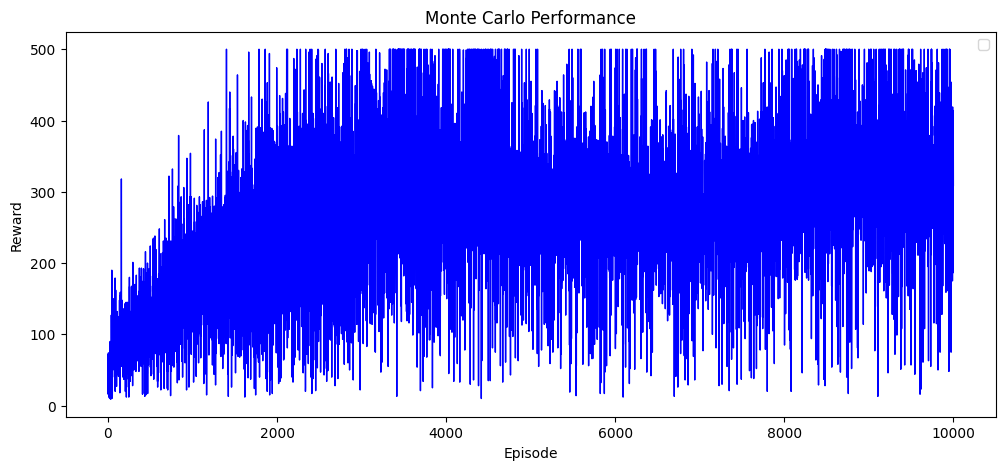

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(monte_carlo_agent.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Monte Carlo Performance')

plt.legend()
plt.show()
plt.savefig('Monte_Carlo_performance.png')

### 1b) Q Learning agent
We now implement a Q learning agent to play through the cart pole game. Q-learning is suitable for this task as it enables the agent to learn an optimal policy that maximizes rewards over time.

The Q_Learning class will:
1. Implement the Q-Learning algorithm
1. Simulate the optimal learned policy
1. Simulate a random policy

Class functions:
- `_ _ init _ _` initialises the class
- `returnIndexState` discretizes a given state into its corresponding index
- `selectAction` selects an action according to the current episode number to learn a strategy
- `simulateEpisodes` iterates through all episodes to learn the strategy
- `simulateLearnedStrategy` with the learnt policy, run a simulation
- `save_pickle` saves the learnt model as a pickle file
- `load_pickle` loads the learnt model from a pickle file

Hyperparameters:
1. Learning Rate (α)
  - High α (e.g., 0.9) → Q-values update quickly, but learning can be unstable.
  - Low α (e.g., 0.1) → Learning is slower, but Q-values converge more smoothly.
2. Discount Factor (γ)
  - High γ (e.g., 0.99) → Agent prioritizes long-term rewards.
  - Low γ (e.g., 0.5) → Agent prioritizes short-term rewards.
3. Exploration Rate (ε)
  - High ε (e.g., 1.0) → More exploration, but learning may be inefficient.
  - Low ε (e.g., 0.01) → Less exploration, but the agent might get stuck in suboptimal policies.
  - Decay ε over time → Helps the agent transition from exploration to exploitation.

#### The learning strategy
We have decided to train our model by learning through 30,000 episodes, where the first 5% episodes (1,500 ep) is dedicated to exploration.

Subsequently, the model will learn using a chosen ε (epsilon) value to play between the exploitative and explorative trade-offs in learning.

For the remaining 40% episodes (12,000 ep), the model should have a good "game sense", so we decided to decay the ε value over time for this chapter of the episode to encourage more exploitation.

In [ ]:
class Q_Learning:
    ###########################################################################
    #   START - __init__ function
    ###########################################################################
    # INPUTS:
    # env - Cart Pole environment
    # alpha - learning rate
    # gamma - discount factor
    # epsilon - exploration rate
    # numberEpisodes - total number of simulation episodes

    # numberOfBins - this is a 4 dimensional list that defines the number of grid points
    # for state discretization
    # that is, this list contains number of bins for every state entry,
    # we have 4 entries, that is,
    # discretization for cart position, cart velocity, pole angle, and pole angular velocity

    # lowerBounds - lower bounds (limits) for discretization, list with 4 entries:
    # lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # upperBounds - upper bounds (limits) for discretization, list with 4 entries:
    # upper bounds on cart position, cart velocity, pole angle, and pole angular velocity

    # usePickle (optional) - loads model from pickle file if set to true. when set to true, all other parameters are not needed

    def __init__(self,env=None,alpha=None,gamma=None,epsilon=None,numberEpisodes=None,numberOfBins=None,lowerBounds=None,upperBounds=None, usePickle=False):
        if usePickle:
          # if using pickle, loads the class attributes with the saved values
          self.load_pickle('Qlearn.pkl')

        else:
          self.env=env
          self.alpha=alpha
          self.gamma=gamma
          self.epsilon=epsilon
          self.actionNumber=env.action_space.n
          self.numberEpisodes=numberEpisodes
          self.numberOfBins=numberOfBins
          self.lowerBounds=lowerBounds
          self.upperBounds=upperBounds
          self.history = []

          # this list stores sum of rewards in every learning episode
          self.sumRewardsEpisode=[]

          # this matrix is the action value function matrix
          self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))

    ###########################################################################
    #   END - __init__ function
    ###########################################################################

    ###########################################################################
    # START: function "returnIndexState"
    ###########################################################################
    # for the given 4-dimensional state, and discretization grid defined by
    # numberOfBins, lowerBounds, and upperBounds, this function will return
    # the index tuple (4-dimensional) that is used to index entries of the
    # of the QvalueMatrix


    # INPUTS:
    # state - state list/array, 4 entries:
    # cart position, cart velocity, pole angle, and pole angular velocity

    # OUTPUT: 4-dimensional tuple defining the indices of the QvalueMatrix
    # that correspond to "state" input
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]

        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])

        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)

        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])
    ###########################################################################
    #   END - function "returnIndexState"
    ###########################################################################

    ###########################################################################
    #    START - function for selecting an action: epsilon-greedy approach
    ###########################################################################
    # this function selects an action on the basis of the current state
    # INPUTS:
    # state - state for which to compute the action
    # index - index of the current episode
    def selectAction(self,state,index):

        # first 5% of episodes we select completely random actions to have enough exploration
        if index<(self.numberEpisodes*0.05):
            return np.random.choice(self.actionNumber)

        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()

        # for the remaining 40% episodes, we slowly start to decrease the epsilon parameter to encourage more exploration
        if index>(self.numberEpisodes*0.6):
            self.epsilon=0.9999*self.epsilon

        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actionNumber)

        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
    ###########################################################################
    #    END - function selecting an action: epsilon-greedy approach
    ###########################################################################


    ###########################################################################
    #    START - function for simulating learning episodes
    ###########################################################################

    def simulateEpisodes(self):
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):
            if indexEpisode==(self.numberEpisodes*0.05):
              print("end of 5% exploration phase")
            elif indexEpisode==(self.numberEpisodes*0.6):
              print("start of remaining 40% epsilon decrease phase")

            # list that stores rewards per episode - this is necessary for keeping track of convergence
            rewardsEpisode=[]

            # reset the environment at the beginning of every episode
            stateS=self.env.reset()
            stateS=list(stateS)

            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state

                stateSIndex=self.returnIndexState(stateS)

                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)


                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_) = self.env.step(actionA)

                rewardsEpisode.append(reward)

                stateSprime=list(stateSprime)

                stateSprimeIndex=self.returnIndexState(stateSprime)

                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])

                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error

                # set the current state to the next state
                stateS=stateSprime
            if(indexEpisode % 100 == 0):
              print(f"Sum of rewards {np.sum(rewardsEpisode)} for episode number {indexEpisode}")
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))

        # save learning into pickle file
        self.save_pickle('Qlearn.pkl')


    ###########################################################################
    #    END - function for simulating learning episodes
    ###########################################################################


    ###########################################################################
    #    START - function for simulating the final learned optimal policy
    ###########################################################################
    # INPUTS:
    # renderVideo (optional) - renders video if set to true. otherwise only outputs final simulation results

    # OUTPUT:
    # env1 - created Cart Pole environment
    # obtainedRewards - a list of obtained rewards during time steps of a single episode

    # simulate the final learned optimal policy
    def simulateLearnedStrategy(self, renderVideo=False):
      if renderVideo:
        env1 = RecordVideo(gym.make("CartPole-v1"), "./video")
        currentState = env1.reset()
        obtainedRewards=[]
        done = False
        while not done:
            env1.render()
            #your agent goes here
            action = np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, done, info = env1.step(action)
            obtainedRewards.append(reward)
        env1.close()
        show_video()
        print(f"Simulation ended. Results achieved: {np.sum(obtainedRewards)}")
        return
      else:
        env1=gym.make('CartPole-v1',render_mode='human')
        currentState=env1.reset()
        env1.render()
        timeSteps=1000 # limit to 1000 time steps
        # obtained rewards at every time step
        obtainedRewards=[]

        for timeIndex in range(timeSteps):
            # print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, info =env1.step(actionInStateS)
            obtainedRewards.append(reward)
            # time.sleep(0.05)
            if (terminated):
                # time.sleep(1)
                break
        return obtainedRewards,env1
    ###########################################################################
    #    END - function for simulating the final learned optimal policy
    ###########################################################################


    ###########################################################################
    #    START - function for serializing Q learning model as a pickle file
    ###########################################################################
    # INPUTS:
    # filename - the output filename of the pickle file

    def save_pickle(self, filename: str):
      with open(filename, 'wb') as file:
            # serialize file
            pickle.dump({
                'alpha': self.alpha,
                'gamma': self.gamma,
                'epsilon': self.epsilon,
                'actionNumber': self.actionNumber,
                'numberEpisodes': self.numberEpisodes,
                'numberOfBins': self.numberOfBins,
                'lowerBounds': self.lowerBounds,
                'upperBounds': self.upperBounds,
                'sumRewardsEpisode': self.sumRewardsEpisode,
                'Qmatrix': self.Qmatrix
            }, file)
    ###########################################################################
    #    END - function for serializing Q learning model as a pickle file
    ###########################################################################


    ###########################################################################
    #    START - function for de-serializing Q learning model as a pickle file
    ###########################################################################
    # INPUTS:
    # filename - the filename of the pickle file
    def load_pickle(self, filename: str):
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                # deserialze file
                data = pickle.load(file)
                self.alpha = data['alpha']
                self.gamma = data['gamma']
                self.epsilon = data['epsilon']
                self.actionNumber = data['actionNumber']
                self.numberEpisodes = data['numberEpisodes']
                self.numberOfBins = data['numberOfBins']
                self.lowerBounds = data['lowerBounds']
                self.upperBounds = data['upperBounds']
                self.sumRewardsEpisode = data['sumRewardsEpisode']
                self.Qmatrix = data['Qmatrix']
            #print(f"pickle loaded.\nalpha: {self.alpha}\ngamma: {self.gamma}\nepsilon: {self.epsilon}\nepisodes: {self.numberEpisodes}")
        else:
            print("Pickle file not found!")
            pass
    ###########################################################################
    #    END - function for de-serializing Q learning model as a pickle file
    ###########################################################################


We set the Q learning hyperparameters of

`α (alpha)` : 0.1

`γ (gamma)` : 0.9

`ε (epsilon)` : 0.2

Then, run and save the model as Q_model

In [ ]:
def start_learning_Q(a,g,e, episodes) -> Q_Learning:
  # define the parameters
  alpha=a
  gamma=g
  epsilon=e
  #print(f"a = {a}, g = {g}, e = {e}")
  numberEpisodes=episodes

  # create a Q_Learning object
  Q1=Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds)
  # run the Q-Learning algorithm
  Q1.simulateEpisodes()
  print("Done learning")
  return Q1

In [ ]:
Q_model = start_learning_Q(0.1,1,0.3, 30000)

Sum of rewards 27.0 for episode number 0
Sum of rewards 25.0 for episode number 100
Sum of rewards 23.0 for episode number 200
Sum of rewards 14.0 for episode number 300
Sum of rewards 26.0 for episode number 400
Sum of rewards 12.0 for episode number 500
Sum of rewards 14.0 for episode number 600
Sum of rewards 23.0 for episode number 700
Sum of rewards 28.0 for episode number 800
Sum of rewards 12.0 for episode number 900
Sum of rewards 26.0 for episode number 1000
Sum of rewards 32.0 for episode number 1100
Sum of rewards 15.0 for episode number 1200
Sum of rewards 28.0 for episode number 1300
Sum of rewards 19.0 for episode number 1400
end of 5% exploration phase
Sum of rewards 69.0 for episode number 1500
Sum of rewards 66.0 for episode number 1600
Sum of rewards 98.0 for episode number 1700
Sum of rewards 69.0 for episode number 1800
Sum of rewards 129.0 for episode number 1900
Sum of rewards 22.0 for episode number 2000
Sum of rewards 84.0 for episode number 2100
Sum of rewards 

Show learning performance over episodes. Notice that in the first 5% of the training episodes, the rewards attained were pretty low at xx.

Eventually when the epsilon greedy approach was kicked in for the next segment of training, the rewards attained started to rise.

Finally, the remaining 40% of the training segment seemed to yield more consistent results as the model followed its trained knowledge more.

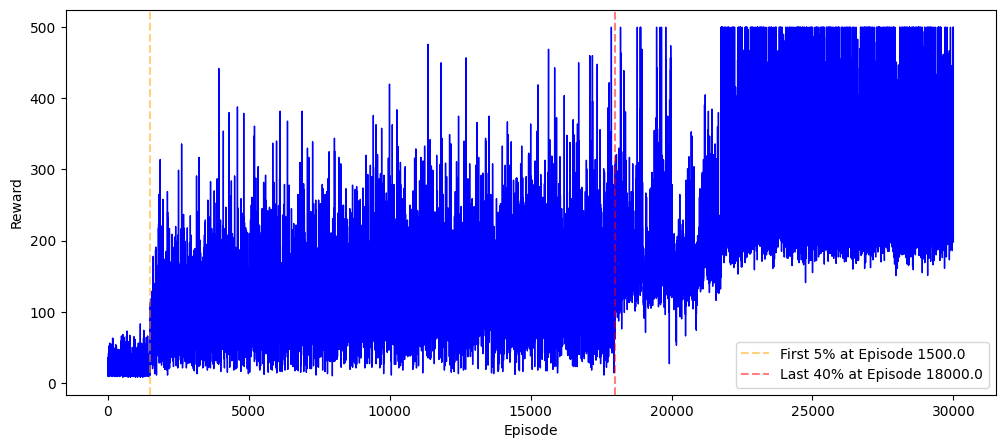

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q_model.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
seg12 = Q_model.numberEpisodes*0.05
seg23 = Q_model.numberEpisodes*0.6
plt.axvline(x=seg12, color='orange', linestyle='--', alpha=0.5, label=f'First 5% at Episode {seg12}')
plt.axvline(x=seg23, color='red', linestyle='--', alpha=0.5, label=f'Last 40% at Episode {seg23}')

plt.legend()
plt.show()
plt.savefig('Q_Learning_performance.png')

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

### 2a) Monte Carlo Agent


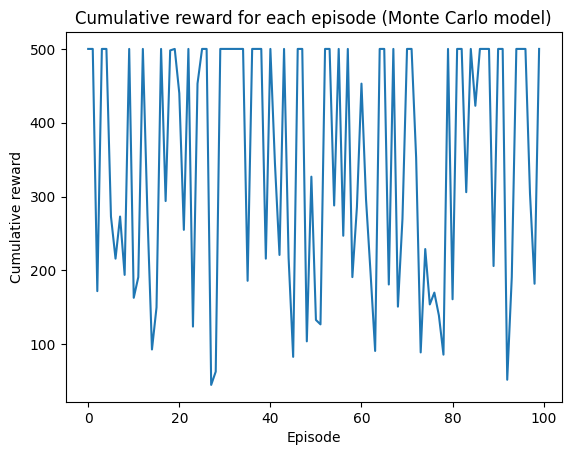

In [ ]:
monte_carlo_results = []
for _ in range(100):
  results = monte_carlo_agent.simulateLearnedStrategy()
  monte_carlo_results.append(np.sum(results))

plt.plot(monte_carlo_results)
plt.title('Cumulative reward for each episode (Monte Carlo model)')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

In [ ]:
print("Average cumulative reward:", np.mean(monte_carlo_results))
print("Is my agent good enough?", np.mean(monte_carlo_results) > 195)

Average cumulative reward: 348.28
Is my agent good enough? True


### 2b) Q-Learning Agent


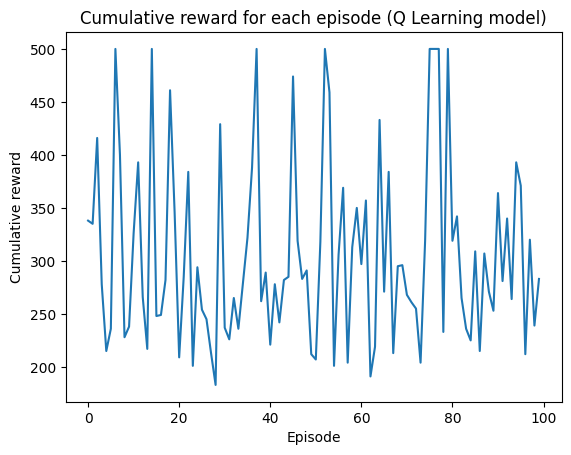

In [ ]:
Q_episode_results = []
for _ in range(100):
  (results, env1) = Q_model.simulateLearnedStrategy()
  Q_episode_results.append(np.sum(results))

plt.plot(Q_episode_results)
plt.title('Cumulative reward for each episode (Q Learning model)')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", np.mean(Q_episode_results))
print("Is my agent good enough?", np.mean(Q_episode_results) > 195)

Average cumulative reward: 305.92
Is my agent good enough? True


## Task 3: Render one episode played by the agent

### 3a) Monte Carlo Agent


In [ ]:
monte_carlo_agent = MonteCarloAgent(usePickle=True)
monte_carlo_agent.simulateLearnedStrategy(renderVideo=True)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Simulation ended. Results achieved: 500.0


### 3b) Q-Learning Agent


In [ ]:
Q_model = Q_Learning(usePickle=True)
Q_model.simulateLearnedStrategy(renderVideo=True)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Simulation ended. Results achieved: 204.0


# References
1. Detailed Explanation and Python Implementation of the Q-Learning Algorithm with Tests in Cart Pole OpenAI Gym Environment – Reinforcement Learning Tutorial”. Technical Report, Number 6, Aleksandar Haber, (2023), Publisher: www.aleksandarhaber.com, Link: https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/
2. Q-Learning in Reinforcement Learning - https://www.geeksforgeeks.org/q-learning-in-python/
3. Mastering Monte Carlo: How To Simulate Your Way to Better Machine Learning Models - https://towardsdatascience.com/mastering-monte-carlo-how-to-simulate-your-way-to-better-machine-learning-models-6b57ec4e5514/